# Telco Churn Prediction (Logistic Regression)

In [1]:
import os
import re
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from IPython.display import display

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_score,
    recall_score,
)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = "."


## 1) Load/merge, cleaning, feature selection, modeling

In [4]:
def _clean_numeric_strings(s: pd.Series) -> pd.Series:
    """Convert currency/commas/%/mixed strings to numeric; invalid -> NaN."""
    return pd.to_numeric(
        s.astype(str).str.replace(r"[^0-9\.\-]", "", regex=True),
        errors="coerce",
    )



def make_onehot_encoder(min_frequency: int = 200):
    """Compatibility helper: scikit-learn changed OneHotEncoder 'sparse' -> 'sparse_output'."""
    try:
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_frequency, sparse_output=True)
    except TypeError:
        # older scikit-learn
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_frequency, sparse=True)

def load_and_merge(data_dir: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load 3 extracts and merge into one modeling table + load data dictionary."""
    p1 = os.path.join(data_dir, "telcodata_extract1.csv")
    p2 = os.path.join(data_dir, "telcodata_extract2.csv")
    p3 = os.path.join(data_dir, "telcodata_extract3.csv")
    ddp = os.path.join(data_dir, "Data_dictionary_clean_combined.csv")

    df1 = pd.read_csv(p1, low_memory=False)
    df2 = pd.read_csv(p2)
    df3 = pd.read_csv(p3)
    dd = pd.read_csv(ddp)

    # Align key name
    df3 = df3.rename(columns={"cust_id": "Customer_ID"})

    # Merge all
    df = df1.merge(df2, on="Customer_ID").merge(df3, on="Customer_ID")
    return df, dd


def prep_features(df: pd.DataFrame, dd: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, str], List[str]]:
    """Clean numeric fields (based on data dictionary) and return type maps."""
    type_map = dd.set_index("variable")["type"].to_dict()
    label_map = dd.set_index("variable")["label"].to_dict()

    num_cols = [c for c in df.columns if type_map.get(c) == "Num"]

    out = df.copy()
    for c in num_cols:
        if c in {"Customer_ID", "churn", "upsell_xsell"}:
            continue
        if out[c].dtype == "object":
            out[c] = _clean_numeric_strings(out[c])

    return out, label_map, num_cols


def build_dataset(df: pd.DataFrame, dd: pd.DataFrame) -> Tuple[pd.DataFrame, List[str], List[str], List[str], pd.DataFrame]:
    """Select a leakage-resistant feature set for churn modeling."""
    dfc, label_map, _num_cols = prep_features(df, dd)

    target = "churn"
    exclude_always = {"Customer_ID", target, "upsell_xsell"}
    all_features = [c for c in dfc.columns if c not in exclude_always]

    # 1) Drop obvious "current month" fields (often leak churn status)
    leak_cols = [
        "voice_tot_bill_mou_curr",
        "tot_voice_chrgs_curr",
        "mb_data_usg_m01",
        "mb_data_usg_roamm01",
        "tot_mb_data_curr",
        "tot_mb_data_roam_curr",
        "data_prem_chrgs_curr",
    ]
    all_features = [c for c in all_features if c not in leak_cols]

    # 2) Remove call-center intent fields (usually occur near/after churn decision)
    call_center_like = {
        "nbr_contacts",
        "calls_TS_acct",
        "calls_care_acct",
        "calls_care_3mavg_acct",
        "calls_care_6mavg_acct",
        "res_calls_3mavg_acct",
        "res_calls_6mavg_acct",
        "last_rep_sat_score",
        "network_mention",
        "service_mention",
        "price_mention",
        "call_center",
        "issue_level1",
        "issue_level2",
        "call_category_1",
        "call_category_2",
        "resolution",
    }
    all_features = [c for c in all_features if c not in call_center_like]

    # 3) Remove suspension/status fields (often label-adjacent)
    suspension_like = {"count_of_suspensions_6m", "avg_days_susp"}
    all_features = [c for c in all_features if c not in suspension_like]

    # 4) Remove sensitive demographic proportions (fairness/compliance)
    sensitive_cs = {
        "cs_hispanic",
        "cs_caucasian",
        "cs_afr_amer",
        "cs_other",
        "cs_ttl_male",
        "cs_ttl_female",
    }
    all_features = [c for c in all_features if c not in sensitive_cs]

    # 5) Remove ID-like/high-cardinality geography represented as numbers
    all_features = [c for c in all_features if c not in {"zipcode_primary", "state"}]

    # Identify numeric vs categorical by dtype (after cleaning)
    num_features = [c for c in all_features if pd.api.types.is_numeric_dtype(dfc[c])]
    cat_features = [c for c in all_features if c not in num_features]

    # Optional: city is extremely high-cardinality; drop for interpretability
    cat_features = [c for c in cat_features if c != "city"]

    all_features = num_features + cat_features

    # Build exclusion report
    excluded = sorted(list(set([c for c in dfc.columns if c not in exclude_always]) - set(all_features) - set(leak_cols)))
    excluded_df = pd.DataFrame(
        {
            "variable": excluded,
            "label": [label_map.get(v, v) for v in excluded],
            "reason": [
                "Leakage / not available before churn"
                if v in (set(leak_cols) | call_center_like | suspension_like)
                else "Removed for fairness/compliance"
                if v in sensitive_cs
                else "ID-like/high-cardinality"
                if v in {"zipcode_primary", "state", "city"}
                else "Excluded"
                for v in excluded
            ],
        }
    )

    return dfc, all_features, num_features, cat_features, excluded_df


def fit_logistic_regression(
    dfc: pd.DataFrame,
    features: List[str],
    num_features: List[str],
    cat_features: List[str],
    random_state: int = 42,
) -> Tuple[Pipeline, pd.DataFrame, pd.Series, pd.Series]:
    """Fit a regularized logistic regression model with preprocessing."""
    X = dfc[features]
    y = dfc["churn"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=random_state, stratify=y
    )

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", make_onehot_encoder(min_frequency=200)),
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features),
        ],
        remainder="drop",
    )

    model = LogisticRegression(
        solver="liblinear",
        penalty="l2",
        class_weight="balanced",
        max_iter=300,
    )

    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)

    proba = pd.Series(clf.predict_proba(X_test)[:, 1], index=y_test.index)
    return clf, X_test, y_test, proba


@dataclass
class ModelOutputs:
    roc_auc: float
    pr_auc: float
    baseline_rate: float
    top10_threshold: float
    top10_precision: float
    top10_recall: float
    confusion: np.ndarray
    decile_table: pd.DataFrame
    coef_table: pd.DataFrame
    data_quality: pd.DataFrame
    excluded: pd.DataFrame


def summarize_model(
    clf: Pipeline,
    dfc: pd.DataFrame,
    features: List[str],
    excluded_df: pd.DataFrame,
    random_state: int = 42,
) -> ModelOutputs:
    """Compute AUCs, lift/deciles, coefficients, and data-quality tables."""
    X = dfc[features]
    y = dfc["churn"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=random_state, stratify=y
    )
    clf.fit(X_train, y_train)
    score = clf.predict_proba(X_test)[:, 1]

    roc_auc = float(roc_auc_score(y_test, score))
    pr_auc = float(average_precision_score(y_test, score))
    baseline = float(y_test.mean())

    # Top 10% threshold
    top10 = float(np.quantile(score, 0.9))
    pred = (score >= top10).astype(int)
    cm = confusion_matrix(y_test, pred)
    prec = float(precision_score(y_test, pred))
    rec = float(recall_score(y_test, pred))

    # Decile lift table (D10 highest risk)
    t = pd.DataFrame({"y": y_test.values, "score": score})
    t["decile"] = pd.qcut(t["score"], 10, labels=False, duplicates="drop")
    dec = (
        t.groupby("decile")
        .agg(
            customers=("y", "size"),
            churners=("y", "sum"),
            churn_rate=("y", "mean"),
            avg_score=("score", "mean"),
        )
        .reset_index()
        .sort_values("decile", ascending=False)
        .reset_index(drop=True)
    )
    dec["label"] = [f"D{i}" for i in range(10, 0, -1)]
    dec["lift"] = dec["churn_rate"] / baseline
    dec["cum_churners"] = dec["churners"].cumsum()
    dec["capture_rate"] = dec["cum_churners"] / dec["churners"].sum()
    decile_table = dec[["label", "customers", "churners", "churn_rate", "lift", "capture_rate", "avg_score"]]

    # Coefficients (standardized / one-hot)
    feature_names = clf.named_steps["preprocess"].get_feature_names_out()
    coefs = clf.named_steps["model"].coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["odds_ratio"] = np.exp(coef_df["coef"])
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

    # Data quality
    dq = pd.DataFrame(
        {
            "variable": features,
            "dtype": [str(dfc[c].dtype) for c in features],
            "missing_pct": [float(dfc[c].isna().mean()) for c in features],
            "n_unique": [int(dfc[c].nunique(dropna=True)) for c in features],
        }
    ).sort_values("missing_pct", ascending=False)

    return ModelOutputs(
        roc_auc=roc_auc,
        pr_auc=pr_auc,
        baseline_rate=baseline,
        top10_threshold=top10,
        top10_precision=prec,
        top10_recall=rec,
        confusion=cm,
        decile_table=decile_table,
        coef_table=coef_df,
        data_quality=dq,
        excluded=excluded_df,
    )


def build_excel_report(out_path: str, dd: pd.DataFrame, outputs: ModelOutputs, sample: pd.DataFrame) -> None:
    """Create a multi-sheet Excel report (no external dependencies beyond openpyxl)."""
    from openpyxl import Workbook
    from openpyxl.utils import get_column_letter
    from openpyxl.styles import Alignment, Font, PatternFill
    from openpyxl.worksheet.table import Table, TableStyleInfo

    header_fill = PatternFill("solid", fgColor="0B1F3A")
    header_font = Font(color="FFFFFF", bold=True)
    center = Alignment(horizontal="center", vertical="center", wrap_text=True)

    def style_header(ws, row: int) -> None:
        for cell in ws[row]:
            cell.fill = header_fill
            cell.font = header_font
            cell.alignment = center

    def add_table(ws, ref: str, name: str) -> None:
        tab = Table(displayName=name, ref=ref)
        tab.tableStyleInfo = TableStyleInfo(name="TableStyleMedium9", showRowStripes=True)
        ws.add_table(tab)

    wb = Workbook()
    wb.remove(wb.active)

    # README
    ws = wb.create_sheet("README")
    ws["A1"] = "Telco churn — Logistic Regression report"
    ws["A1"].font = Font(size=16, bold=True, color="0B1F3A")
    ws["A3"] = f"ROC-AUC: {outputs.roc_auc:.3f} | PR-AUC: {outputs.pr_auc:.3f} | Baseline churn: {outputs.baseline_rate:.2%}"
    ws["A4"] = (
        f"Top 10% risk threshold: {outputs.top10_threshold:.3f} | "
        f"Precision: {outputs.top10_precision:.1%} | Recall: {outputs.top10_recall:.1%}"
    )
    ws.column_dimensions["A"].width = 120

    # Data dictionary
    ws = wb.create_sheet("DATA_DICTIONARY")
    ws.append(list(dd.columns))
    style_header(ws, 1)
    for r in dd.itertuples(index=False):
        ws.append(list(r))
    add_table(ws, f"A1:G{ws.max_row}", "DataDict")

    # Data quality
    ws = wb.create_sheet("DATA_QUALITY")
    ws.append(list(outputs.data_quality.columns))
    style_header(ws, 1)
    for r in outputs.data_quality.itertuples(index=False):
        ws.append(list(r))
    add_table(ws, f"A1:D{ws.max_row}", "DataQuality")

    # Excluded
    ws = wb.create_sheet("EXCLUDED")
    ws.append(list(outputs.excluded.columns))
    style_header(ws, 1)
    for r in outputs.excluded.itertuples(index=False):
        ws.append(list(r))
    add_table(ws, f"A1:C{ws.max_row}", "Excluded")

    # Performance
    ws = wb.create_sheet("PERFORMANCE")
    ws.append(["metric", "value"])
    style_header(ws, 1)
    rows = [
        ("ROC_AUC", outputs.roc_auc),
        ("PR_AUC", outputs.pr_auc),
        ("Baseline churn", outputs.baseline_rate),
        ("Top10 threshold", outputs.top10_threshold),
        ("Top10 precision", outputs.top10_precision),
        ("Top10 recall", outputs.top10_recall),
    ]
    for k, v in rows:
        ws.append([k, float(v)])

    ws.append([])
    ws.append(["Confusion matrix (Top10)", "Pred 0", "Pred 1"])
    style_header(ws, ws.max_row)
    ws.append(["Actual 0", int(outputs.confusion[0, 0]), int(outputs.confusion[0, 1])])
    ws.append(["Actual 1", int(outputs.confusion[1, 0]), int(outputs.confusion[1, 1])])

    # Deciles
    ws = wb.create_sheet("DECILE_LIFT")
    ws.append(list(outputs.decile_table.columns))
    style_header(ws, 1)
    for r in outputs.decile_table.itertuples(index=False):
        ws.append(list(r))
    add_table(ws, f"A1:G{ws.max_row}", "DecileLift")

    # Coefs (top 50)
    ws = wb.create_sheet("COEFFICIENTS")
    top = outputs.coef_table.head(50).copy()
    ws.append(list(top.columns))
    style_header(ws, 1)
    for r in top.itertuples(index=False):
        ws.append(list(r))
    add_table(ws, f"A1:D{ws.max_row}", "Coefs")

    # Sample
    ws = wb.create_sheet("SAMPLE_CLEAN")
    ws.append(list(sample.columns))
    style_header(ws, 1)
    for r in sample.itertuples(index=False):
        ws.append(list(r))
    last_col = get_column_letter(sample.shape[1])
    add_table(ws, f"A1:{last_col}{ws.max_row}", "Sample")

    wb.save(out_path)


## 2) Load data, build features, train Logistic Regression, compute AUC

In [5]:
# Load + merge
df_raw, dd = load_and_merge(DATA_DIR)

print("Merged dataset shape:", df_raw.shape)
print("Target distribution (churn):")
display(df_raw["churn"].value_counts(dropna=False).to_frame("count"))
print("Churn rate:", df_raw["churn"].mean())

# Build modeling dataset (feature selection + leakage control)
dfc, features, num_features, cat_features, excluded_df = build_dataset(df_raw, dd)

print("\nSelected features:", len(features))
print(" - numeric:", len(num_features))
print(" - categorical:", len(cat_features))
print("\nExcluded variables (count):", excluded_df.shape[0])
display(excluded_df.head(10))

# Fit model + evaluate
clf, X_test, y_test, proba_test = fit_logistic_regression(dfc, features, num_features, cat_features, random_state=RANDOM_STATE)

roc_auc = roc_auc_score(y_test, proba_test)
pr_auc  = average_precision_score(y_test, proba_test)

print(f"ROC-AUC (test): {roc_auc:.3f}")
print(f"PR-AUC  (test): {pr_auc:.3f}")


Merged dataset shape: (56557, 115)
Target distribution (churn):


,count
churn,
0,54203
1,2354


Churn rate: 0.04162172675354068

Selected features: 77
 - numeric: 69
 - categorical: 8

Excluded variables (count): 28


,variable,label,reason
0,avg_days_susp,Days Suspended Last 6M,Leakage / not available before churn
1,call_category_1,call_category_1,Leakage / not available before churn
2,call_category_2,call_category_2,Leakage / not available before churn
3,call_center,call_center,Leakage / not available before churn
4,calls_TS_acct,Number Calls Tech Support,Leakage / not available before churn
5,calls_care_3mavg_acct,Number Calls Care Center 3 Month Avg,Leakage / not available before churn
6,calls_care_6mavg_acct,Number Calls Care Center 6 Month Avg,Leakage / not available before churn
7,calls_care_acct,Number Calls Care Center,Leakage / not available before churn
8,city,city,ID-like/high-cardinality
9,count_of_suspensions_6m,Times Suspended Last 6M,Leakage / not available before churn


c:\Users\Admin\Downloads\NICE_test_data\Nice_test_data\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


ROC-AUC (test): 0.932
PR-AUC  (test): 0.267


## 3) Business view: Top-decile targeting, lift & capture

In [6]:
outputs = summarize_model(clf, dfc, features, excluded_df, random_state=RANDOM_STATE)

print("Baseline churn rate:", f"{outputs.baseline_rate:.2%}")
print("Top 10% threshold:", f"{outputs.top10_threshold:.3f}")
print("Top 10% precision:", f"{outputs.top10_precision:.1%}")
print("Top 10% recall:", f"{outputs.top10_recall:.1%}")
print("\nConfusion matrix (Top10 threshold):")
display(pd.DataFrame(outputs.confusion, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))

print("\nDecile lift table (D10 = highest risk):")
display(outputs.decile_table)


c:\Users\Admin\Downloads\NICE_test_data\Nice_test_data\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Baseline churn rate: 4.16%
Top 10% threshold: 0.645
Top 10% precision: 30.1%
Top 10% recall: 72.4%

Confusion matrix (Top10 threshold):


,Pred 0,Pred 1
Actual 0,15076,1186
Actual 1,195,511



Decile lift table (D10 = highest risk):


,label,customers,churners,churn_rate,lift,capture_rate,avg_score
0,D10,1697,511,0.301120,7.237107,0.723796,0.887745
1,D9,1697,137,0.080731,1.940281,0.917847,0.469878
2,D8,1697,46,0.027107,0.651481,0.983003,0.290611
3,D7,1696,7,0.004127,0.099197,0.992918,0.184086
4,D6,1697,1,0.000589,0.014163,0.994334,0.133617
5,D5,1697,2,0.001179,0.028325,0.997167,0.104064
6,D4,1696,1,0.000590,0.014171,0.998584,0.080881
7,D3,1697,0,0.000000,0.000000,0.998584,0.059928
8,D2,1697,0,0.000000,0.000000,0.998584,0.040848
9,D1,1697,1,0.000589,0.014163,1.000000,0.021864


## 4) Feature importance (coefficients & odds ratios)

> Logistic Regression is interpretable: coefficients show how features move churn odds (after preprocessing: numeric standardized, categorical one-hot).


In [7]:
# Top drivers by absolute coefficient
display(outputs.coef_table.head(20))

# (Optional) show the strongest positive drivers only
top_pos = outputs.coef_table.sort_values("coef", ascending=False).head(15)
top_neg = outputs.coef_table.sort_values("coef", ascending=True).head(15)

print("Strongest POSITIVE drivers (increase churn odds):")
display(top_pos)

print("Strongest NEGATIVE drivers (decrease churn odds):")
display(top_neg)


,feature,coef,odds_ratio,abs_coef
0,num__tot_drpd_pr1,2.085390,8.047732,2.085390
1,cat__product_plan_desc_Legacy SL,1.057221,2.878360,1.057221
2,cat__product_plan_desc_Lotta Value FT,-0.815803,0.442284,0.815803
3,cat__lifestage_EARLY TENURED,0.810840,2.249797,0.810840
4,cat__product_plan_desc_Lotta Minutes SL,0.655859,1.926798,0.655859
5,num__forecast_region,0.648831,1.913302,0.648831
6,cat__product_plan_desc_Lotta Minutes Classic FT,-0.588224,0.555313,0.588224
7,cat__rp_pooled_ind_infrequent_sklearn,-0.579580,0.560134,0.579580
8,cat__lifestage_EXPIRY,-0.537467,0.584226,0.537467
9,num__state_long,0.512475,1.669417,0.512475


Strongest POSITIVE drivers (increase churn odds):


,feature,coef,odds_ratio,abs_coef
0,num__tot_drpd_pr1,2.085390,8.047732,2.085390
1,cat__product_plan_desc_Legacy SL,1.057221,2.878360,1.057221
3,cat__lifestage_EARLY TENURED,0.810840,2.249797,0.810840
4,cat__product_plan_desc_Lotta Minutes SL,0.655859,1.926798,0.655859
5,num__forecast_region,0.648831,1.913302,0.648831
9,num__state_long,0.512475,1.669417,0.512475
17,cat__product_plan_desc_Unlimited SL,0.351543,1.421259,0.351543
19,cat__product_plan_desc_Alot More Minutes SL,0.317125,1.373174,0.317125
22,cat__rp_pooled_ind_Y,0.295842,1.344257,0.295842
26,num__zip_lat,0.272458,1.313189,0.272458


Strongest NEGATIVE drivers (decrease churn odds):


,feature,coef,odds_ratio,abs_coef
2,cat__product_plan_desc_Lotta Value FT,-0.815803,0.442284,0.815803
6,cat__product_plan_desc_Lotta Minutes Classic FT,-0.588224,0.555313,0.588224
7,cat__rp_pooled_ind_infrequent_sklearn,-0.579580,0.560134,0.579580
8,cat__lifestage_EXPIRY,-0.537467,0.584226,0.537467
10,cat__product_plan_desc_Alot More Minutes FT,-0.493874,0.610258,0.493874
11,cat__product_plan_desc_Unlimited FT,-0.467106,0.626814,0.467106
12,cat__handset_age_grp_< 24 Months,-0.459517,0.631589,0.459517
13,cat__rp_pooled_ind_N,-0.412981,0.661675,0.412981
14,cat__credit_class_prime,-0.394782,0.673827,0.394782
15,cat__product_plan_desc_infrequent_sklearn,-0.393446,0.674728,0.393446


## 5) Export Excel report (deliverable)

This creates a multi-sheet Excel file you can attach to your submission.


In [8]:
OUT_XLSX = os.path.join(DATA_DIR, "Telco_Churn_LogReg_Analysis.xlsx")

# Include a small clean sample for review (first 200 rows)
sample_cols = ["Customer_ID"] + features + ["churn"]
sample = dfc[sample_cols].head(200).copy()

build_excel_report(OUT_XLSX, dd, outputs, sample)

print("Saved:", OUT_XLSX)


Saved: .\Telco_Churn_LogReg_Analysis.xlsx


## 6) Save churn risk scores for all customers

In [9]:
# Fit on full dataset to score everyone (for deployment / campaign list)
X_full = dfc[features]
y_full = dfc["churn"].astype(int)

clf.fit(X_full, y_full)
scores = clf.predict_proba(X_full)[:, 1]

scored = pd.DataFrame({
    "Customer_ID": dfc["Customer_ID"].values,
    "churn": y_full.values,
    "score": scores
}).sort_values("score", ascending=False)

OUT_SCORES = os.path.join(DATA_DIR, "Telco_Churn_Scored.csv")
scored.to_csv(OUT_SCORES, index=False)

print("Saved:", OUT_SCORES)
display(scored.head(10))


c:\Users\Admin\Downloads\NICE_test_data\Nice_test_data\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Saved: .\Telco_Churn_Scored.csv


,Customer_ID,churn,score
40731,2802274,1,1.0
47414,3311567,1,1.0
15498,880826,1,1.0
1697,76757,1,1.0
42623,2943934,1,1.0
20724,1280140,1,1.0
37585,2562528,0,1.0
36232,2457816,1,1.0
8616,373931,1,1.0
30895,2057810,0,1.0


## 7) EDA

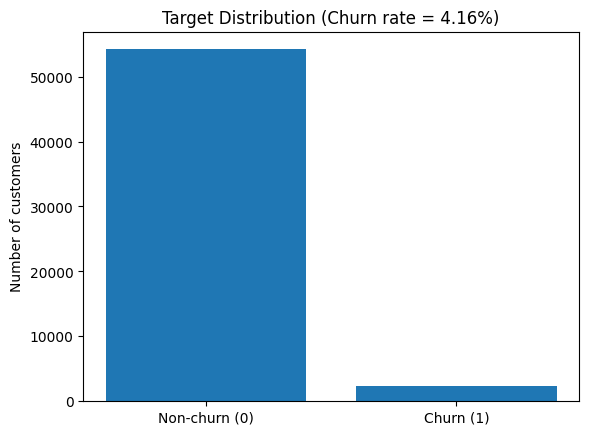

C:\Users\Admin\AppData\Local\Temp\ipykernel_7360\3299800111.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Non-churn (0)", "Churn (1)"], showfliers=False)


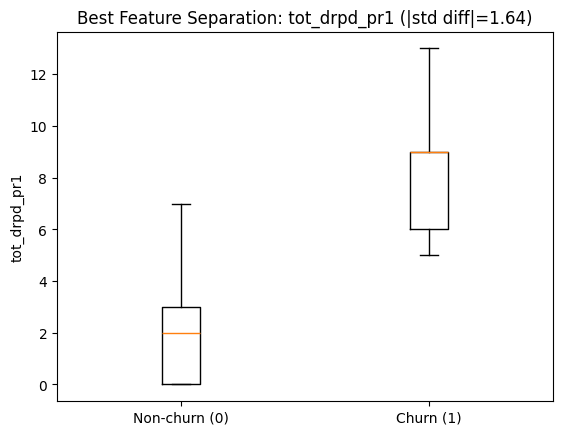

Chosen feature: tot_drpd_pr1


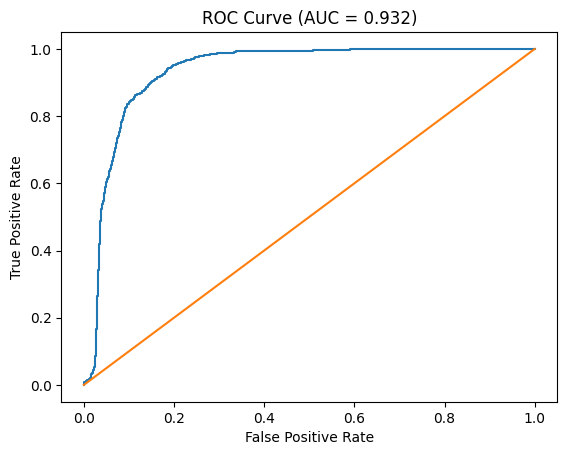

In [13]:
# CHART 1 — Target imbalance (Churn distribution)
import matplotlib.pyplot as plt

y_all = df_raw["churn"].astype(int)
counts = y_all.value_counts().sort_index()  # 0 then 1

plt.figure()
plt.bar(["Non-churn (0)", "Churn (1)"], counts.values)
plt.title(f"Target Distribution (Churn rate = {y_all.mean():.2%})")
plt.ylabel("Number of customers")
plt.show()
# CHART 2 — Feature EDA (best numeric separator: churn vs non-churn boxplot)
import numpy as np
import matplotlib.pyplot as plt

y_all = dfc["churn"].astype(int)

best_feat = None
best_abs = -1.0

for c in num_features:
    std = dfc[c].std()
    if std is None or np.isnan(std) or std == 0:
        continue
    mean1 = dfc.loc[y_all == 1, c].mean()
    mean0 = dfc.loc[y_all == 0, c].mean()
    sdiff = (mean1 - mean0) / std
    if np.isfinite(sdiff) and abs(sdiff) > best_abs:
        best_abs = abs(sdiff)
        best_feat = c

if best_feat is None:
    print("No suitable numeric feature found for boxplot.")
else:
    data0 = dfc.loc[y_all == 0, best_feat].dropna().values
    data1 = dfc.loc[y_all == 1, best_feat].dropna().values

    plt.figure()
    plt.boxplot([data0, data1], labels=["Non-churn (0)", "Churn (1)"], showfliers=False)
    plt.title(f"Best Feature Separation: {best_feat} (|std diff|={best_abs:.2f})")
    plt.ylabel(best_feat)
    plt.show()

    print("Chosen feature:", best_feat)
# CHART 3 — Model EDA (ROC curve + AUC)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

fpr, tpr, _ = roc_curve(y_test, np.array(proba_test))
auc = roc_auc_score(y_test, np.array(proba_test))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
